In [2]:
"""
Notebook for analysing the dataset distribution accross the differents birds species.

1- We will first load all the annotations file into a Dataframe.
2- Plot the samples count per classes
3- Analyze the duration of samples per classes
4- Inspect the distribution of the classes of interests.
5- Identify the final list of classes of interests.

"""

'\nNotebook for analysing the dataset distribution accross the differents birds species.\n\n1- We will first load all the annotations file into a Dataframe.\n2- Plot the samples count per classes\n3- Analyze the duration of samples per classes\n4- Inspect the distribution of the classes of interests.\n5- Identify the final list of classes of interests.\n\n'

In [1]:
import os
import random
random.seed(42) 
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
from tqdm import tqdm
import uuid
from sklearn.model_selection import train_test_split
from  st_nips4bplus_labeller import compute_mel_spectrogram

2022-07-17 10:24:15.312 
  command:

    streamlit run /Users/test/miniconda3/envs/scologan/lib/python3.7/site-packages/ipykernel_launcher.py [ARGUMENTS]


<Figure size 1440x720 with 0 Axes>

<Figure size 72x72 with 0 Axes>

## Global variables

In [4]:
AUDIOS_PATH_ROOT = "/Users/test/Documents/Projects/Master/nips4bplus/raw_audio"
ANNOTATIONS_PATH_ROOT = "/Users/test/Documents/Projects/Master/nips4bplus/raw_audio/new_labels"
OUT_FOLDER  = "/Users/test/Documents/Projects/Master/nips4bplus/splits_temp"
os.makedirs(OUT_FOLDER, exist_ok=False)
ANNOTATIONS_PATH = glob.glob(ANNOTATIONS_PATH_ROOT + "/*.csv")
SR=22050
len(ANNOTATIONS_PATH)

514

## Load annotations

In [5]:
data = []
for annotation_filepath in ANNOTATIONS_PATH:
    with open(annotation_filepath, 'r') as fs:
        lines = fs.read().splitlines()
        for row in lines:
            if row:
                row = row.split(',')
                row[-1] = row[-1].strip()
                row.insert(2, annotation_filepath)
                data.append(row)

df = pd.DataFrame.from_records(data, columns=["start_time", "duration", "filename","classname"])
df['duration'] = pd.to_numeric(df['duration'])
df = df.drop_duplicates()
df = df[df['classname'] != 'Unknown']
df.head(), len(df)


(            start_time  duration  \
 0  0.09650793699999999  0.401270   
 1                  0.0  1.847619   
 2          2.040634921  1.532698   
 3           3.79047619  1.084444   
 4          4.403809524  0.472381   
 
                                             filename    classname  
 0  /Users/test/Documents/Projects/Master/nips4bpl...  Galthe_song  
 1  /Users/test/Documents/Projects/Master/nips4bpl...  Alaarv_song  
 2  /Users/test/Documents/Projects/Master/nips4bpl...  Alaarv_song  
 3  /Users/test/Documents/Projects/Master/nips4bpl...  Alaarv_song  
 4  /Users/test/Documents/Projects/Master/nips4bpl...  Galcri_call  ,
 961)

In [6]:
class_count = df['classname'].value_counts()
class_count.head()

Erirub_song    29
Turphi_song    28
Turmer_call    26
Sylcan_song    25
Galcri_call    25
Name: classname, dtype: int64

In [19]:
species_of_interest = class_count[class_count > 20].index.tolist()

# len(species_of_interest), species_of_interest

In [29]:
# import plotly.graph_objects as go
import plotly.express as px
tmp = class_count.to_frame()
tmp = tmp.reset_index()
tmp = tmp.rename(columns={"index": "classname", "classname": "count"})
tmp = tmp.sort_values(by=['classname'])
# print(tmp)
fig = px.bar(tmp[tmp['count']>20], x='classname', y='count')
fig.show()

      classname  count
36  Aegcau_call     11
6   Alaarv_song     22
31  Anttri_song     13
19  Butbut_call     17
56  Carcan_call      8
..          ...    ...
58  Tibtom_song      7
23  Trotro_song     16
2   Turmer_call     26
34  Turmer_song     12
1   Turphi_song     28

[82 rows x 2 columns]


## Duration of species of interests.

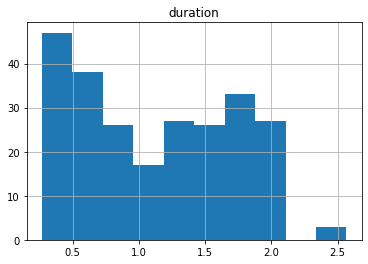

In [9]:
temp_df = df.loc[df['classname'].isin(species_of_interest)]
temp_df.hist(column="duration")
df = temp_df


In [11]:
df['classname'].value_counts()

Erirub_song    29
Turphi_song    28
Turmer_call    26
Sylcan_song    25
Galcri_call    25
Parate_song    25
Cetcet_song    22
Alaarv_song    22
Sylcan_call    21
Serser_song    21
Name: classname, dtype: int64

In [8]:
for g, d in df.groupby("classname"):
    # print(g)
    if g == "Turphi_song":
        # print(d.head())
        print(d['filename'].apply(lambda x: os.path.basename(x)))
        

29     revised-annotation_train086.csv
30     revised-annotation_train086.csv
61     revised-annotation_train468.csv
62     revised-annotation_train468.csv
63     revised-annotation_train468.csv
225    revised-annotation_train122.csv
342    revised-annotation_train190.csv
343    revised-annotation_train190.csv
379    revised-annotation_train031.csv
472    revised-annotation_train579.csv
473    revised-annotation_train579.csv
579    revised-annotation_train628.csv
580    revised-annotation_train628.csv
607    revised-annotation_train414.csv
608    revised-annotation_train414.csv
615    revised-annotation_train428.csv
616    revised-annotation_train428.csv
635    revised-annotation_train039.csv
653    revised-annotation_train171.csv
739    revised-annotation_train176.csv
740    revised-annotation_train176.csv
741    revised-annotation_train176.csv
813    revised-annotation_train058.csv
877    revised-annotation_train502.csv
878    revised-annotation_train502.csv
879    revised-annotation

# Export Dataset

all_files_df = []

AUDIO_CACHE = {}
for cls, group in tqdm(df.groupby("classname")):
    if len(group) < 20:
        continue
    # for row in tqdm(group.iterrows()):
    train, test = train_test_split(group, test_size=0.25)
    print(len(train), len(test))
    temp_split = {"train":train, "test":test}
    for data_set, set_ in temp_split.items():
        for sample in set_.iterrows():
            try:
                annotation_path = sample[1]['filename'] 
                start_time = float(sample[1]['start_time'])
                duration = float(sample[1]['duration'])
                class_ = sample[1]['classname'].strip()
                audio_path = os.path.join(
                    AUDIOS_PATH_ROOT,
                    "train",
                    os.path.basename(annotation_path).split('-')[1].replace('.csv', '.wav').replace('annotation_train', 'nips4b_birds_trainfile')
                )
                # print(audio_path)
                if audio_path not in AUDIO_CACHE:
                    AUDIO_CACHE[audio_path] = librosa.load(audio_path, sr=SR)
                audio, sr = AUDIO_CACHE[audio_path]
                # start_ = max(0, start_time-0.01)
                # end_ = start_ + min(duration+0.01, librosa.get_duration(y=audio ,sr=SR))
                start_ = start_time
                end_ = start_ + duration
                start_, end_ = librosa.time_to_samples([start_, end_], sr=SR)
                y_sample = audio[start_:end_]
                out_filename = os.path.basename(audio_path)
                out_filename, ext = os.path.splitext(out_filename)
                out_filename = f"{out_filename}-{str(uuid.uuid4())[0:6]}"
                out_filename += ext
                outfile = os.path.join(
                    OUT_FOLDER,
                    f"cleaned_{data_set}",
                    class_,
                    out_filename
                )
                # print(start_, end_, len(y_sample))
                os.makedirs(os.path.dirname(outfile), exist_ok=True)
                # librosa.output.write_wav(outfile, y_sample, SR)
                # print(outfile)
                temp_path = outfile.split('/')
                temp_path = f"{os.path.sep}".join(temp_path[-3:])
                # print(temp_path)
                data_folder = temp_path.split(os.path.sep)[0]
                out_txt = os.path.join(OUT_FOLDER, data_folder+'.txt')
                # print(out_txt)
                with open(os.path.join(out_txt), 'a') as fs:
                    fs.write(f"{temp_path}\n")

            except Exception as e:
                print("Error while processing", annotation_filepath, e)
#             break
    #     break
    # break

